# bayesian linear regression

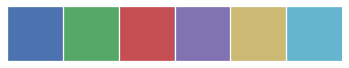

In [1]:
from edward.models import Normal
import tensorflow as tf
import matplotlib.pyplot as plt
import edward as ed
import seaborn as sns
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.animation import FuncAnimation

matplotlib.interactive(True)
plt.style.use('seaborn-talk')

sns.palplot(sns.color_palette())


In [2]:
sess = ed.get_session()
ed.set_seed(42)

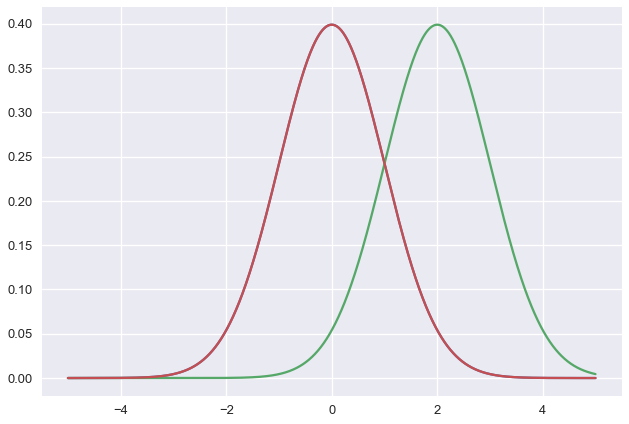

In [3]:
x= tf.range(-5.0,5.0,0.001)
plt.plot(*sess.run([x, Normal(loc=tf.ones(1) * 0.0,
                            scale =tf.ones(1)*1.0).prob(x)]))
plt.plot(*sess.run([x, Normal(loc=tf.ones(1)*2.0,
                             scale=tf.ones(1)*1.0).prob(x)]))
plt.plot(*sess.run([x, Normal(loc=tf.ones(1)*0.0,
                             scale=tf.ones(1)*1.0).prob(x)]))

In [9]:
# data
N1 = 10 # number of training data points in first batch 
N2 = 90 # number of training data points in second batch
Np = 10 # number of test data points
D = 1 # number of features

weights_true = sess.run(Normal(loc=tf.ones(D) * 2.0,
                              scale=tf.ones(D) * 0.1)) # unknown true weights
intercept_true = sess.run(Normal(loc=tf.zeros(1),
                                scale=tf.ones(1)))
noise_true = 0.35 # unknown true amount of noise

def build_dataset(N):
    x = Normal(loc=tf.zeros([N,D]), scale=tf.ones([N,D]))
    y = Normal(loc=ed.dot(x,weights_true) + intercept_true, scale=noise_true)
    return sess.run([x,y])

x_train1, y_train1 = build_dataset(N1)
x_train2, y_train2 = build_dataset(N2)
x_test, y_test = build_dataset(Np)

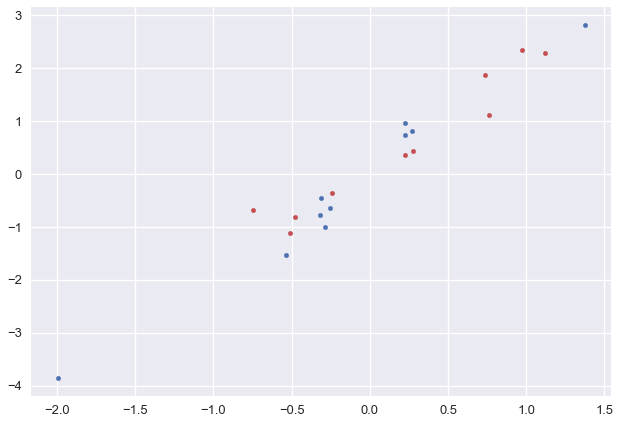

In [11]:
plt.scatter(x_train1, y_train1, s=20.0)
plt.scatter(x_test, y_test,s=20.0,color=sns.color_palette().as_hex()[2])

### Little noise

In [18]:
from edward.models import Empirical, Normal
import numpy as np

In [22]:
# Forward model
x = tf.placeholder(tf.float32,[N1,D])
weights = Normal(loc=tf.zeros(D),scale=tf.ones(D))
intercept = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(x,weights)+ intercept,
          scale=tf.ones(N1) ) # with more noise 

In [23]:
# BACKWARD MODEL
T = 10000
q_weights = Empirical(params=tf.Variable(tf.zeros([T,D])))
q_intercept = Empirical(params=tf.Variable(tf.zeros([T,1])))

In [24]:
# inference 
inference = ed.HMC(latent_vars={weights: q_weights,
                                intercept: q_intercept},
                   data={x: x_train1,
                         y: y_train1})
inference.run(step_size=0.01 / N1, n_steps=20)

10000/10000 [100%] ██████████████████████████████ Elapsed: 99s | Acceptance Rate: 1.000

[[<matplotlib.lines.Line2D at 0x1256f4d30>],

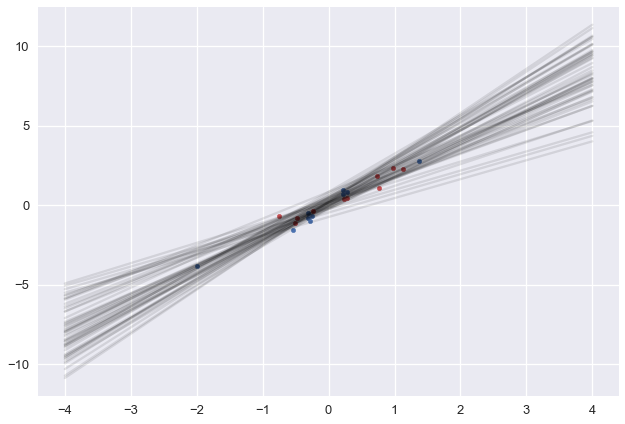

In [25]:
# criticism
plt.scatter(x_train1, y_train1, s=20.0)
plt.scatter(x_test, y_test, s=20.0, color = sns.color_palette().as_hex()[2])

xp = tf.placeholder(tf.float32, [2,D])
[plt.plot(np.linspace(-4.0,4.0,2),
         sess.run(ed.dot(xp, q_weights.params[t]) + q_intercept.params[t],
                 {xp:np.linspace(-4.0,4.0,2)[:,np.newaxis]}),
         color='k',alpha=0.1)
for t in range(int(T/2),T,int(T/100))]

In [26]:
y_post = ed.copy(y, {weights: q_weights, 
                    intercept: q_intercept})

In [27]:
print('Mean squared error on test data:')
print(ed.evaluate('mean_squared_error', data ={x: x_test, y_post: y_test}))

print("mean absolute error on test data")
print(ed.evaluate('mean_absolute_error', data={x: x_test, y_post: y_test}))

Mean squared error on test data:
0.111212
mean absolute error on test data
0.338317


In [28]:
# prior on noise

In [ ]:
from edward.models import InverseGamma